In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import scipy.stats as st

import matplotlib.pyplot as plt
from matplotlib import patches

from sklearn.preprocessing import scale, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer
from sklearn.metrics import accuracy_score

from yellowbrick.cluster import SilhouetteVisualizer

from six import StringIO
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#configuración warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None


In [2]:
df_preprocesado = pd.read_csv('df_preprocesado.csv')
df_pca = pd.read_csv('df_pca.csv')

## 3. Clasificación

### a) Construcción del target

In [3]:
df_target= df_preprocesado.copy()
df_pca_target= df_pca.copy()

#### Creación de las nuevas columnas

Iniciamos creando la nueva variable cualitativa `tipo_precio`, la cual será la variable target posteriormente.

In [4]:
df_target["tipo_precio"] = ""
df_pca_target["tipo_precio"] = ""

In [5]:
df_target.head()

,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,tipo_precio
0,2021-09-09,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.000000,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,
1,2021-09-09,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.000000,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,
2,2021-09-09,-34.610027,-58.401934,Once,Departamento,4.0,2.0,124.408727,104.0,146000.0,Venta departamento 4 ambientes Once,
3,2021-09-09,-34.631621,-58.416825,Boedo,PH,4.0,2.0,97.673080,73.0,250000.0,PH - Boedo,
4,2021-09-09,-34.623886,-58.412746,Boedo,PH,2.0,1.0,61.000000,46.0,100000.0,PH 2 Ambientes c/Patio HECHO A NUEVO,


Calculamos el precio por metro cuadrado de cada propiedad y lo guardamos en una nueva variable cuantitativa `pxm2`

In [6]:
lista=[]
for i in range(len(df_target)):
    aux= (df_target.iloc[i]['property_price'])/(df_target.iloc[i]['property_surface_total'])
    lista.append(aux)

In [7]:
df_target["pxm2"]= lista

In [8]:
df_target.head()

,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,tipo_precio,pxm2
0,2021-09-09,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.000000,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,,1429.310345
1,2021-09-09,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.000000,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,,1414.285714
2,2021-09-09,-34.610027,-58.401934,Once,Departamento,4.0,2.0,124.408727,104.0,146000.0,Venta departamento 4 ambientes Once,,1173.551114
3,2021-09-09,-34.631621,-58.416825,Boedo,PH,4.0,2.0,97.673080,73.0,250000.0,PH - Boedo,,2559.558895
4,2021-09-09,-34.623886,-58.412746,Boedo,PH,2.0,1.0,61.000000,46.0,100000.0,PH 2 Ambientes c/Patio HECHO A NUEVO,,1639.344262


#### Distribucion de la nueva variable

Graficamos la distribución de la variable precio por metro cuadrado (en general)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


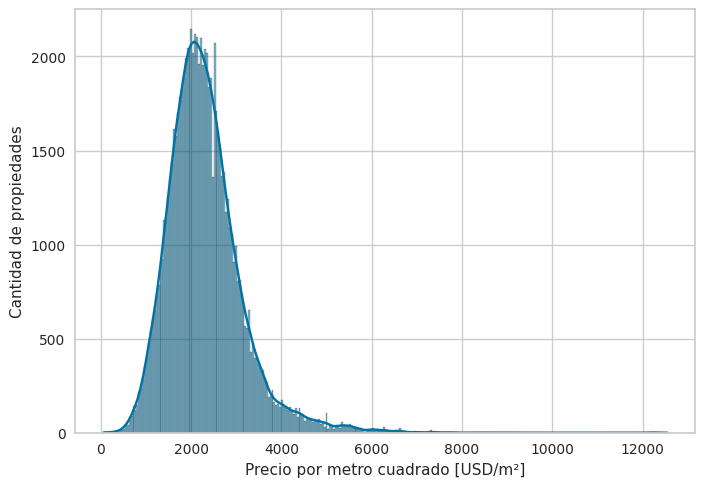

In [9]:
sns.histplot(data=df_target['pxm2'], kde=True).set(xlabel="Precio por metro cuadrado [USD/m²]",ylabel="Cantidad de propiedades")
plt.show()

Ahora procedemos a graficar la distribución de la misma variable, pero solamente según el tipo de propiedad:

- Propiedad tipo casa:

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


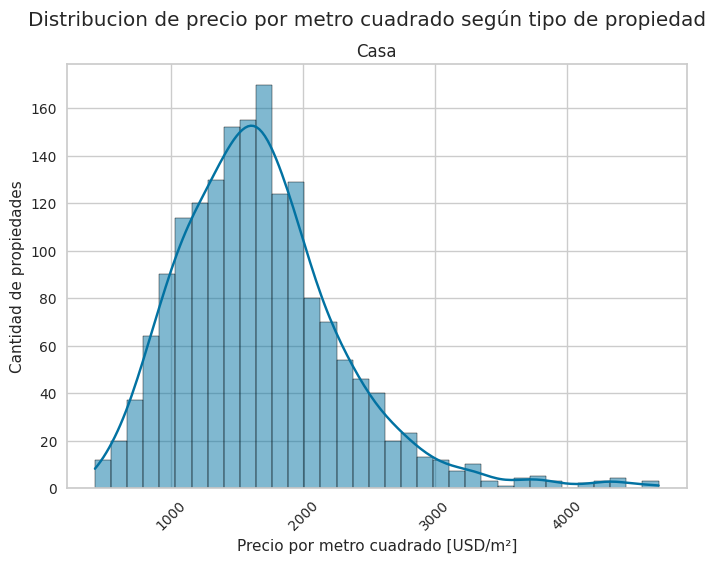

In [10]:
plt.suptitle('Distribucion de precio por metro cuadrado según tipo de propiedad')

properties_with_house_type_cond = df_target['property_type']  == 'Casa'
sns_hist=sns.histplot(data=df_target.loc[properties_with_house_type_cond,'pxm2'], kde=True).set(xlabel="Precio por metro cuadrado [USD/m²]",ylabel="Cantidad de propiedades", title="Casa")
plt.xticks(rotation=45)
plt.show()

- Propiedad tipo PH:

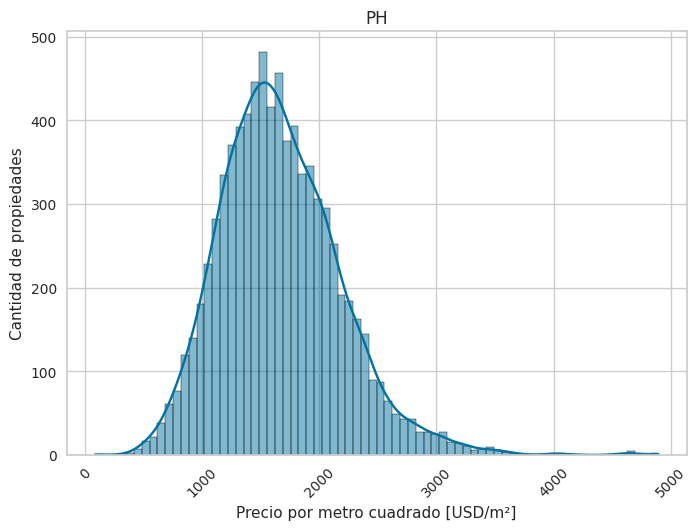

In [11]:


properties_with_PH_type_cond = df_target['property_type']  == 'PH'
sns_hist=sns.histplot(data=df_target.loc[properties_with_PH_type_cond,'pxm2'], kde=True).set(xlabel="Precio por metro cuadrado [USD/m²]",ylabel="Cantidad de propiedades", title="PH")
plt.xticks(rotation=45)
plt.show()

- Propiedad tipo Departamento:

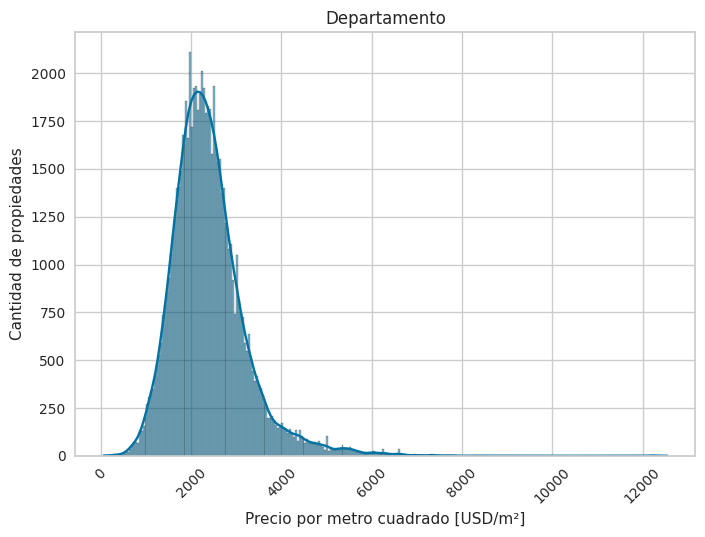

In [12]:
properties_with_dept_type_cond = df_target['property_type']  == 'Departamento'
sns_hist=sns.histplot(data=df_target.loc[properties_with_dept_type_cond,'pxm2'], kde=True).set(xlabel="Precio por metro cuadrado [USD/m²]",ylabel="Cantidad de propiedades", title="Departamento")
plt.xticks(rotation=45)
plt.show()


Una vez ya creada la nueva columna tipo_precio procedemos a clasificar en Alto, medio y bajo teniendo en cuenta el precio x metro cuadrado de cada propiedad.

Para esto  evaluaremos las siguientes alternativas propuestas por el enunciado para establecer los límites de cada categoría:


#### Evaluación y decisión de criterio para clasificación de variable target

##### 1. Dividir la variable pxm2 en 3 intervalos con igual cantidad de observaciones.

In [13]:
categories=["bajo","medio","alto"]
df_target["pxm2_intervalos_iguales"] = pd.qcut(df_target["pxm2"],q=3, labels=categories)

In [14]:
df_target.head()

,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,tipo_precio,pxm2,pxm2_intervalos_iguales
0,2021-09-09,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.000000,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,,1429.310345,bajo
1,2021-09-09,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.000000,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,,1414.285714,bajo
2,2021-09-09,-34.610027,-58.401934,Once,Departamento,4.0,2.0,124.408727,104.0,146000.0,Venta departamento 4 ambientes Once,,1173.551114,bajo
3,2021-09-09,-34.631621,-58.416825,Boedo,PH,4.0,2.0,97.673080,73.0,250000.0,PH - Boedo,,2559.558895,alto
4,2021-09-09,-34.623886,-58.412746,Boedo,PH,2.0,1.0,61.000000,46.0,100000.0,PH 2 Ambientes c/Patio HECHO A NUEVO,,1639.344262,bajo


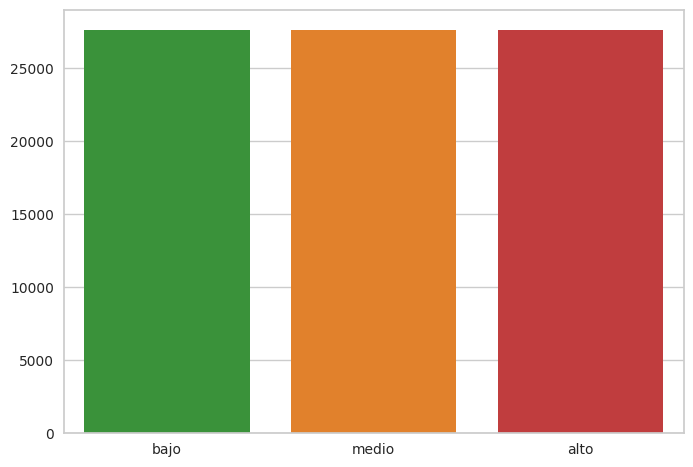

In [15]:
sns.barplot(data=df_target  , x= df_target.groupby(['pxm2_intervalos_iguales']).count().index.tolist() , y=df_target.groupby(['pxm2_intervalos_iguales']).count()['pxm2'].tolist() , palette = ['tab:green', 'tab:orange', 'tab:red'])
plt.show()

In [16]:
print("Podemos observar que la cantidad de precios que fueron asignados como BAJOS corresponde a 1/3 del total ==",df_target['pxm2_intervalos_iguales'].value_counts()['bajo'])
print("\nPodemos observar que la cantidad de precios que fueron asignados como MEDIOS corresponde a 1/3 del total ==",df_target['pxm2_intervalos_iguales'].value_counts()['medio'])
print("\nPodemos observar que la cantidad de precios que fueron asignados como ALTOS corresponde a 1/3 del total ==",df_target['pxm2_intervalos_iguales'].value_counts()['alto'])

Podemos observar que la cantidad de precios que fueron asignados como BAJOS corresponde a 1/3 del total == 27619

Podemos observar que la cantidad de precios que fueron asignados como MEDIOS corresponde a 1/3 del total == 27632

Podemos observar que la cantidad de precios que fueron asignados como ALTOS corresponde a 1/3 del total == 27604


##### 2. Dividir la variable pxm2 en 3 intervalos, el primero con el 25% de las observaciones,el siguiente con el 50% y el último con el 25% de las observaciones restantes.

In [17]:
df_target["pxm2_intervalos_25p_50p_25p"]=pd.qcut(df_target["pxm2"],q=[0,1/4,3/4,1], labels=categories, precision=4)

In [18]:
df_target.head()

,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,tipo_precio,pxm2,pxm2_intervalos_iguales,pxm2_intervalos_25p_50p_25p
0,2021-09-09,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.000000,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,,1429.310345,bajo,bajo
1,2021-09-09,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.000000,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,,1414.285714,bajo,bajo
2,2021-09-09,-34.610027,-58.401934,Once,Departamento,4.0,2.0,124.408727,104.0,146000.0,Venta departamento 4 ambientes Once,,1173.551114,bajo,bajo
3,2021-09-09,-34.631621,-58.416825,Boedo,PH,4.0,2.0,97.673080,73.0,250000.0,PH - Boedo,,2559.558895,alto,medio
4,2021-09-09,-34.623886,-58.412746,Boedo,PH,2.0,1.0,61.000000,46.0,100000.0,PH 2 Ambientes c/Patio HECHO A NUEVO,,1639.344262,bajo,bajo


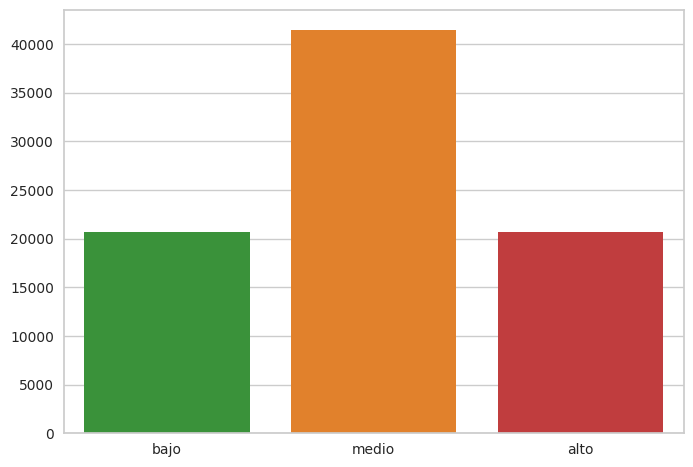

In [19]:
sns.barplot(data=df_target  , x= df_target.groupby(['pxm2_intervalos_25p_50p_25p']).count().index.tolist() , y=df_target.groupby(['pxm2_intervalos_25p_50p_25p']).count()['pxm2'].tolist() , palette = ['tab:green', 'tab:orange', 'tab:red'])
plt.show()

In [20]:
ds_group1=df_target.groupby(['pxm2_intervalos_25p_50p_25p']).count() 
ds_group1

,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,tipo_precio,pxm2,pxm2_intervalos_iguales
pxm2_intervalos_25p_50p_25p,,,,,,,,,,,,,,
bajo,20715,20715,20715,20715,20715,20715,20715,20715,20715,20715,20715,20715,20715,20715
medio,41427,41427,41427,41427,41427,41427,41427,41427,41427,41427,41427,41427,41427,41427
alto,20713,20713,20713,20713,20713,20713,20713,20713,20713,20713,20713,20713,20713,20713


In [21]:
print("\nPodemos observar que la cantidad de precios que fueron asignados como BAJOS corresponde al 25% ==",df_target['pxm2_intervalos_25p_50p_25p'].value_counts()['bajo'])
print("\nPodemos observar que la cantidad de precios que fueron asignados como MEDIOS corresponde al 50% ==",df_target['pxm2_intervalos_25p_50p_25p'].value_counts()['medio'])
print("\nPodemos observar que la cantidad de precios que fueron asignados como ALTOS corresponde al 25% ==",df_target['pxm2_intervalos_25p_50p_25p'].value_counts()['alto'])


Podemos observar que la cantidad de precios que fueron asignados como BAJOS corresponde al 25% == 20715

Podemos observar que la cantidad de precios que fueron asignados como MEDIOS corresponde al 50% == 41427

Podemos observar que la cantidad de precios que fueron asignados como ALTOS corresponde al 25% == 20713


##### 3. Trabajar la variable pxm2 relativa a cada tipo de propiedad y luego dividirla como en el punto anterior.

Dividimos las filas segun tipo de propiedad y las guardamos en distintos datasets

In [22]:
ds_dpto= df_target.loc[df_target["property_type"]=="Departamento"]
ds_ph=df_target.loc[df_target["property_type"]=="PH"]
ds_casa=df_target.loc[df_target["property_type"]=="Casa"]

Analizamos primero los departamentos

In [23]:
ds_dpto["pxm2_dpto_intervalos_25p_50p_25p"]=pd.qcut(ds_dpto["pxm2"],q=[0,1/4,3/4,1], labels=categories, precision=4)
ds_dpto["tipo_precio"]= ds_dpto["pxm2_dpto_intervalos_25p_50p_25p"].values

ds_dpto.head()

,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,tipo_precio,pxm2,pxm2_intervalos_iguales,pxm2_intervalos_25p_50p_25p,pxm2_dpto_intervalos_25p_50p_25p
0,2021-09-09,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.000000,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,bajo,1429.310345,bajo,bajo,bajo
1,2021-09-09,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.000000,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,bajo,1414.285714,bajo,bajo,bajo
2,2021-09-09,-34.610027,-58.401934,Once,Departamento,4.0,2.0,124.408727,104.0,146000.0,Venta departamento 4 ambientes Once,bajo,1173.551114,bajo,bajo,bajo
6,2021-09-09,-34.629398,-58.425852,Boedo,Departamento,2.0,1.0,62.000000,44.0,100000.0,VENTA 2 ambientes EN DUPLEX sin Expensas en Boedo,bajo,1612.903226,bajo,bajo,bajo
7,2021-09-09,-34.620748,-58.412004,Boedo,Departamento,3.0,2.0,59.000000,55.0,185000.0,Venta depto 3 amb Boedo cochera fija y amenities.,alto,3135.593220,alto,alto,alto


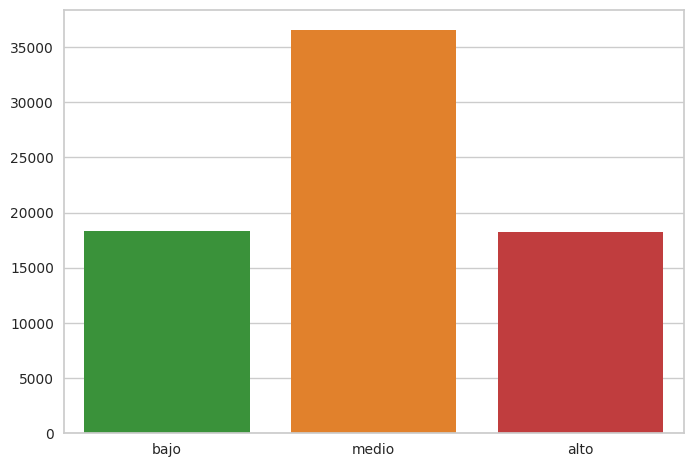

In [24]:
sns.barplot(data=ds_dpto  , x= ds_dpto.groupby(['pxm2_dpto_intervalos_25p_50p_25p']).count().index.tolist() , y=ds_dpto.groupby(['pxm2_dpto_intervalos_25p_50p_25p']).count()['pxm2'].tolist(), palette = ['tab:green', 'tab:orange', 'tab:red'] )
plt.show()

In [25]:
print("Podemos observar que la cantidad de precios que fueron asignados como BAJOS corresponde al 25% ==",ds_dpto['pxm2_dpto_intervalos_25p_50p_25p'].value_counts()['bajo'])
print("\nPodemos observar que la cantidad de precios que fueron asignados como MEDIOS corresponde al 50% ==",ds_dpto['pxm2_dpto_intervalos_25p_50p_25p'].value_counts()['medio'])
print("\nPodemos observar que la cantidad de precios que fueron asignados como ALTOS corresponde al 25% ==",ds_dpto['pxm2_dpto_intervalos_25p_50p_25p'].value_counts()['alto'])

Podemos observar que la cantidad de precios que fueron asignados como BAJOS corresponde al 25% == 18284

Podemos observar que la cantidad de precios que fueron asignados como MEDIOS corresponde al 50% == 36544

Podemos observar que la cantidad de precios que fueron asignados como ALTOS corresponde al 25% == 18270


Luego analizamos los PH

In [26]:
ds_ph["pxm2_ph_intervalos_25p_50p_25p"]=pd.qcut(ds_ph["pxm2"],q=[0,1/4,3/4,1], labels=categories, precision=4)
ds_ph["tipo_precio"]= ds_ph["pxm2_ph_intervalos_25p_50p_25p"].values

ds_ph.head()

,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,tipo_precio,pxm2,pxm2_intervalos_iguales,pxm2_intervalos_25p_50p_25p,pxm2_ph_intervalos_25p_50p_25p
3,2021-09-09,-34.631621,-58.416825,Boedo,PH,4.0,2.0,97.67308,73.0,250000.0,PH - Boedo,alto,2559.558895,alto,medio,alto
4,2021-09-09,-34.623886,-58.412746,Boedo,PH,2.0,1.0,61.00000,46.0,100000.0,PH 2 Ambientes c/Patio HECHO A NUEVO,medio,1639.344262,bajo,bajo,medio
5,2021-09-09,-34.625588,-58.423056,Boedo,PH,4.0,2.0,104.00000,54.0,185000.0,PH Venta PH 3 ambientes + Patio + Terraza Divino,medio,1778.846154,bajo,medio,medio
8,2021-09-09,-34.626595,-58.420019,Boedo,PH,4.0,3.0,111.00000,101.0,110000.0,VENTA DEPARTAMENTO PH 4 AMBIENTES BOEDO C/ TER...,bajo,990.990991,bajo,bajo,bajo
11,2021-09-09,-34.627566,-58.411937,Boedo,PH,4.0,3.0,100.00000,100.0,180000.0,Ph a Estrenar Sanchez de Loria al 1500 100 m2 ...,medio,1800.000000,bajo,medio,medio


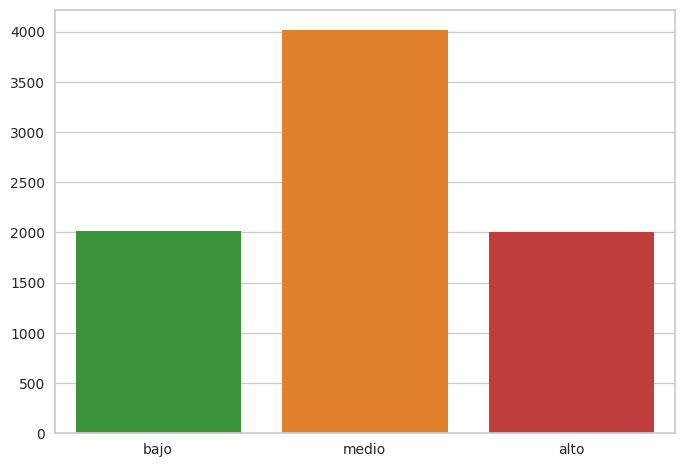

In [27]:
sns.barplot(data=ds_ph  , x= ds_ph.groupby(['pxm2_ph_intervalos_25p_50p_25p']).count().index.tolist() , y=ds_ph.groupby(['pxm2_ph_intervalos_25p_50p_25p']).count()['pxm2'].tolist() , palette = ['tab:green', 'tab:orange', 'tab:red'])
plt.show()

In [28]:
print("Podemos observar que la cantidad de precios que fueron asignados como BAJOS corresponde al 25% ==",ds_ph['pxm2_ph_intervalos_25p_50p_25p'].value_counts()['bajo'])
print("\nPodemos observar que la cantidad de precios que fueron asignados como MEDIOS corresponde al 50% ==",ds_ph['pxm2_ph_intervalos_25p_50p_25p'].value_counts()['medio'])
print("\nPodemos observar que la cantidad de precios que fueron asignados como ALTOS corresponde al 25% ==",ds_ph['pxm2_ph_intervalos_25p_50p_25p'].value_counts()['alto'])

Podemos observar que la cantidad de precios que fueron asignados como BAJOS corresponde al 25% == 2011

Podemos observar que la cantidad de precios que fueron asignados como MEDIOS corresponde al 50% == 4017

Podemos observar que la cantidad de precios que fueron asignados como ALTOS corresponde al 25% == 2009


Y por ultimo analizamos las casas

In [29]:
ds_casa["pxm2_casa_intervalos_25p_50p_25p"]=pd.qcut(ds_casa["pxm2"],q=[0,1/4,3/4,1], labels=categories, precision=4)
ds_casa["tipo_precio"]= ds_casa["pxm2_casa_intervalos_25p_50p_25p"].values

ds_casa.head()

,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,tipo_precio,pxm2,pxm2_intervalos_iguales,pxm2_intervalos_25p_50p_25p,pxm2_casa_intervalos_25p_50p_25p
12,2021-09-09,-34.627566,-58.411937,Boedo,Casa,4.0,3.0,100.0,100.0,180000.0,Ph a Estrenar Sanchez de Loria al 1500 100 m2 ...,medio,1800.000000,bajo,medio,medio
55,2021-09-09,-34.583154,-58.435311,Palermo,Casa,4.0,3.0,181.0,133.0,360000.0,VENTA CASA 2 PLANTAS BALCON TERRAZA PALERMO,alto,1988.950276,medio,medio,alto
145,2021-09-09,-34.627209,-58.524888,Versalles,Casa,4.0,2.0,98.0,93.0,275000.0,Complejo residencial duplex en versalles 4 amb...,alto,2806.122449,alto,alto,alto
201,2021-09-09,-34.627566,-58.411937,San Cristobal,Casa,4.0,3.0,100.0,100.0,180000.0,Ph a Estrenar Sanchez de Loria al 1500 100 m2 ...,medio,1800.000000,bajo,medio,medio
269,2021-12-17,-34.568135,-58.442637,Palermo,Casa,5.0,4.0,260.0,200.0,750000.0,VENTA CASA 5 AMBIENTES CON JARDIN PALERMO,alto,2884.615385,alto,alto,alto


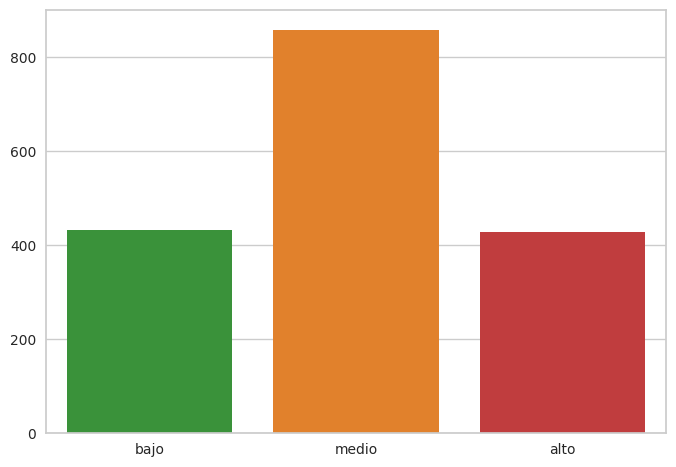

In [30]:
sns.barplot(data=ds_casa  , x= ds_casa.groupby(['pxm2_casa_intervalos_25p_50p_25p']).count().index.tolist() , y=ds_casa.groupby(['pxm2_casa_intervalos_25p_50p_25p']).count()['pxm2'].tolist(), palette = ['tab:green', 'tab:orange', 'tab:red'] )
plt.show()

In [31]:
print("Podemos observar que la cantidad de precios que fueron asignados como BAJOS corresponde al 25% ==",ds_casa['pxm2_casa_intervalos_25p_50p_25p'].value_counts()['bajo'])
print("\nPodemos observar que la cantidad de precios que fueron asignados como MEDIOS corresponde al 50% ==",ds_casa['pxm2_casa_intervalos_25p_50p_25p'].value_counts()['medio'])
print("\nPodemos observar que la cantidad de precios que fueron asignados como ALTOS corresponde al 25% ==",ds_casa['pxm2_casa_intervalos_25p_50p_25p'].value_counts()['alto'])

Podemos observar que la cantidad de precios que fueron asignados como BAJOS corresponde al 25% == 433

Podemos observar que la cantidad de precios que fueron asignados como MEDIOS corresponde al 50% == 858

Podemos observar que la cantidad de precios que fueron asignados como ALTOS corresponde al 25% == 429


Se decide utilizar la tercera opción para la clasificación, dado que consideramos adecuado que se tome un portentaje menor para las categorías de los extremos (precio bajo y precio alto).

A su vez nos parece correcto que se analice dicha categorización distinguiendo según el tipo de propiedad, dado que puede variar lo que se considere un tipo de precio específico si se cambia el tipo de la propiedad. 

Tras haber decidido el ***criterio numero 3*** para clasificar `tipo_precio`, procedemos a juntar los valores recolectados en el analisis previo de dicho criterio (se guardaron en una columna `tipo_precio`, pero estan divididos en cada dataset auxiliar por tipo de propiedad)

In [32]:
properties_with_house_type_cond = df_target['property_type']  == 'Casa'
properties_with_PH_type_cond = df_target['property_type']  == 'PH'
properties_with_dept_type_cond = df_target['property_type']  == 'Departamento'

df_target.loc[properties_with_house_type_cond,'tipo_precio'] = ds_casa['tipo_precio'].values

df_target.loc[properties_with_PH_type_cond,'tipo_precio'] = ds_ph['tipo_precio'].values

df_target.loc[properties_with_dept_type_cond,'tipo_precio'] = ds_dpto['tipo_precio'].values

df_pca_target.loc[:,"tipo_precio"] = df_target["tipo_precio"].values 

In [33]:
# Elimino columnas que quedaron de analizar las otras opciones de criterios
df_target.drop(columns=['pxm2_intervalos_iguales', 'pxm2_intervalos_25p_50p_25p'], inplace=True)

In [34]:
df_target.head()

,start_date,latitud,longitud,place_l3,property_type,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price,property_title,tipo_precio,pxm2
0,2021-09-09,-34.637319,-58.361124,Boca,Departamento,3.0,2.0,58.000000,55.0,82900.0,VENTA TRES AMBIENTES LA BOCA PISO ALTO,bajo,1429.310345
1,2021-09-09,-34.628647,-58.361871,Boca,Departamento,4.0,3.0,70.000000,70.0,99000.0,Departamento - 4 Ambientes - Catalinas Sur,bajo,1414.285714
2,2021-09-09,-34.610027,-58.401934,Once,Departamento,4.0,2.0,124.408727,104.0,146000.0,Venta departamento 4 ambientes Once,bajo,1173.551114
3,2021-09-09,-34.631621,-58.416825,Boedo,PH,4.0,2.0,97.673080,73.0,250000.0,PH - Boedo,alto,2559.558895
4,2021-09-09,-34.623886,-58.412746,Boedo,PH,2.0,1.0,61.000000,46.0,100000.0,PH 2 Ambientes c/Patio HECHO A NUEVO,medio,1639.344262


In [35]:
df_target.to_csv('df_target.csv')
df_pca_target.to_csv('df_pca_target.csv')

#### Visualizacion de propiedades con su tipo de precio geograficamente

Dividimos en 3 grupos segun si su precio es medio , alto y bajo y visualizamos los grupos en una mapa de CABA 

In [36]:
group1=df_target.loc[df_target["tipo_precio"]=="bajo"]
group2=df_target.loc[df_target["tipo_precio"]=="medio"]
group3=df_target.loc[df_target["tipo_precio"]=="alto"]


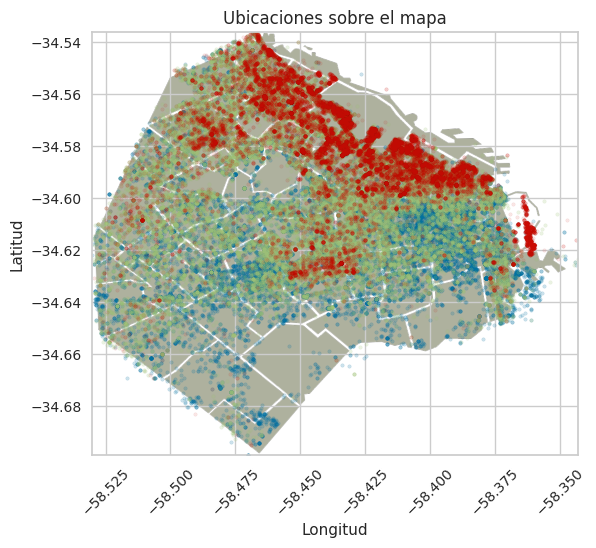

In [37]:
# calculamos limites de la imagen
lat_min = df_target['latitud'].min()
lat_max = df_target['latitud'].max()
long_min = df_target['longitud'].min()
long_max = df_target['longitud'].max()

# seteamos limites del grafico
plt.xlim([long_min, long_max])
plt.ylim([lat_min,lat_max])

# cargamos imagen y ajustamos su tamaño
im = plt.imread("mapa.png")
plt.imshow(im, extent=[long_min-0.0075, long_max+0.0025, lat_min, lat_max])

# graficamos los puntos
plt.scatter(x=group1.longitud,y=group1.latitud ,s=25 ,cmap='viridis', alpha=0.2, marker='.')
plt.scatter(x=group2.longitud,y=group2.latitud ,s=25 ,cmap='viridis', alpha=0.2, marker='.')
plt.scatter(x=group3.longitud,y=group3.latitud ,s=25 ,cmap='viridis', alpha=0.1, marker='.')

plt.title('Ubicaciones sobre el mapa')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.tick_params(axis='x', labelrotation = 45)
plt.show()

#### Comparación con clusters obtenidos anteriormente por KMeans

Como puede observarse, se puede afirmar que hay un grado considerable de similitud entre la segunda clusterización generada por el modelo de KMeans en la sección de Agrupamiento (notebook parte 2), la cuál tenía 3 grupos, de donde se había interpretado que el modelo realizó el agrupamiento a partir del crecimiento de los valores de las variables cuantitativas en general y con la ubicación por medio de las variables latitud y la longitud. 
Los grupos difieren un poco en cuanto a la ubicación relativa de los grupos de las observaciones, pero tienen como principal parecido el "crecimiento" notable principalmente de suroccidente a nororiente.

## [Miguel] ^ <-  Revisar comparación hecha con el punto 2. Por ahi se le puede añadir algo más o corregir algo que no haya expresado bien

### b) Entrenamiento y Predicción

### Modelo 1 : Árbol de decisión

In [38]:
df_target = pd.read_csv('df_target.csv')
df_pca_target = pd.read_csv('df_pca_target.csv')

ds = df_target.copy()

In [39]:
excluir = [
    'property_price',
    'pxm2',
    'tipo_precio',
    'start_date',
    'place_l3',
    'property_title',
]
le = LabelEncoder()
ds = pd.get_dummies(ds, columns=['property_type'], drop_first=True)
cols = list(set(ds.columns) - set(excluir))
ds_trabajo_x = ds[cols].copy()
# ds['tipo_precio'] = le.fit_transform(ds.tipo_precio.values)
ds_trabajo_y = ds["tipo_precio"].copy()


In [40]:
ds_trabajo_y.head()

0     bajo
1     bajo
2     bajo
3     alto
4    medio
Name: tipo_precio, dtype: object

In [41]:
ds_trabajo_x.head()

,Unnamed: 0,property_bedrooms,property_rooms,longitud,property_type_Departamento,property_surface_total,latitud,property_surface_covered,property_type_PH
0,0,2.0,3.0,-58.361124,1,58.000000,-34.637319,55.0,0
1,1,3.0,4.0,-58.361871,1,70.000000,-34.628647,70.0,0
2,2,2.0,4.0,-58.401934,1,124.408727,-34.610027,104.0,0
3,3,2.0,4.0,-58.416825,0,97.673080,-34.631621,73.0,1
4,4,1.0,2.0,-58.412746,0,61.000000,-34.623886,46.0,1


In [42]:
columnas = list(ds_trabajo_x)

In [43]:
ds_trabajo_x = MinMaxScaler().fit_transform(ds_trabajo_x)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(ds_trabajo_x,
                                                    ds_trabajo_y, 
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=2) #semilla

In [45]:
y_train

51819    medio
56593     alto
22702    medio
1710      alto
63845    medio
         ...  
80232     bajo
33867     bajo
31019    medio
44566    medio
72173    medio
Name: tipo_precio, Length: 57998, dtype: object

### Buscamos optimizar hiperparametros con random search
* Falta involucrar PCA

## [Miguel] ->  No estoy seguro pero no deberiamos setear el random_state para la RandomizedSearchCV? No lo estamos haciendo y asi no es reproducible. 
Uffffff de hecho al correr de vuelta salio peor de horrible 

In [46]:
##KFOLD CV Random Search para buscar el mejor arbol (los mejores atributos, hiperparametros,etc)

#Cantidad de combinaciones que quiero porbar
n=20

#Conjunto de parámetros que quiero usar
params_grid = {
                'criterion':['gini','entropy'],
                'min_samples_leaf':list(range(1,15)),
                'min_samples_split': list(range(2,15)),
                'ccp_alpha':np.linspace(0,0.05,n), 
                'max_depth':list(range(10,25))
              }
                
#Cantidad de splits para el Cross Validation
folds=10

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = tree.DecisionTreeClassifier(random_state=2) 

#Metrica que quiero optimizar Accuracy Score
scorer_fn = make_scorer(accuracy_score)

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator = base_tree,
                              param_distributions = params_grid,
                              scoring = scorer_fn,
                              cv = kfoldcv,
                              n_jobs = -1,
                              n_iter = n) 

#Busco los hiperparamtros que optimizan Accuracy Score
randomcv.fit(x_train, y_train);

#Mejor métrica
print(randomcv.best_score_)

0.5357254342306342


### Creamos el arbol, lo entrenamos y predecimos los valores de test

In [47]:
##Creamos un clasificador con hiperparámetros 

tree_model = tree.DecisionTreeClassifier(random_state=2).set_params(**randomcv.best_params_)

#Entrenamos el modelo
arbol = tree_model.fit(X = x_train, y = y_train)

#Realizamos una predicción sobre el set de test
y_pred = arbol.predict(x_test)

### Graficamos el arbol generado (una porcion representativa)

In [48]:
plt.figure(figsize=(100,100))

tree_plot_completo=tree.plot_tree(arbol,
                                 feature_names=columnas,
                                 filled=True,
                                 rounded=True,
                                 class_names=categories,
                                 max_depth=3,
                                 fontsize=50)
plt.show(tree_plot_completo)

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


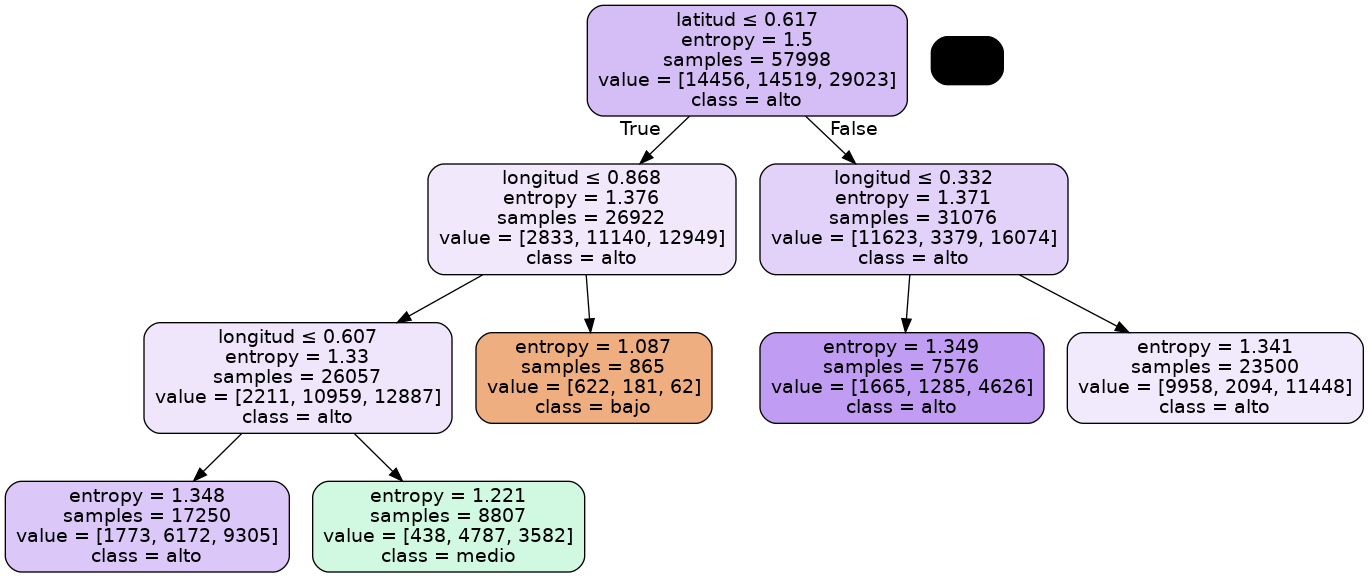

In [49]:
dot_data = StringIO()
export_graphviz(arbol,
                out_file=dot_data,  
                filled=True,
                rounded=True,
                special_characters=True,
                feature_names=columnas,
                class_names=categories,
                max_depth=3)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### Analizamos distintos aspectos del árbol de decision entrenado

#### Analizamos cuales columnas fueron mas decisivas para las predicciones

<AxesSubplot:xlabel='importancia', ylabel='propiedad'>

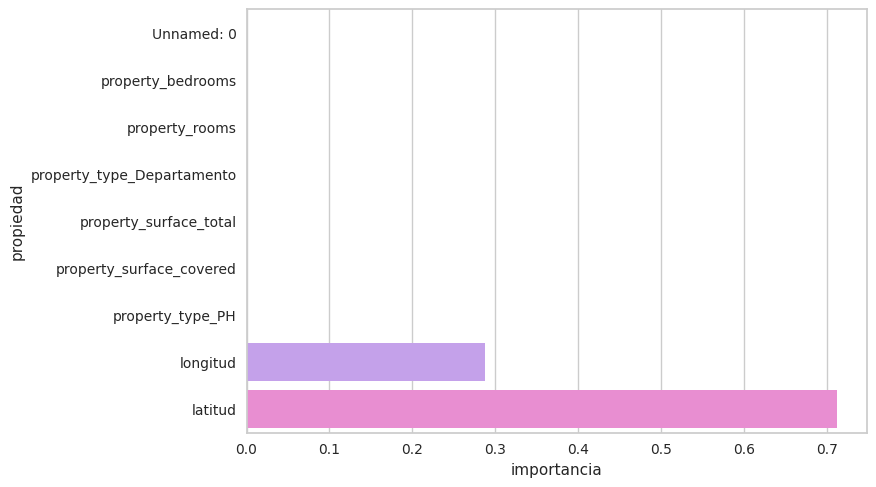

In [50]:
importancia_columna = pd.DataFrame(zip(columnas, arbol.feature_importances_), columns=['propiedad','importancia'])
importancia_columna.sort_values(['importancia'], axis=0, inplace=True)

sns.barplot(y=importancia_columna['propiedad'], x=importancia_columna['importancia'])

#### Analizamos los parametros elegidos por random search para este arbol

In [51]:
for param, valor in randomcv.best_params_.items():
    print(f'{param} -> {valor}')

min_samples_split -> 11
min_samples_leaf -> 3
max_depth -> 17
criterion -> entropy
ccp_alpha -> 0.010526315789473684


#### Análisis del arbol y sus parametros

Tanto por la lista de importancia de los atributos como por lo visto en el árbol podemos ver que las siguientes propiedades son las que mas definen las predicciones:

* latitud
* longitud

Y por lo que se puede visualizar en el arbol, hubiesemos pensado que estas siguientes propiedades también serían decisivas, ya que se evaluan en varias oportunidades en comienzos del árbol:

Además podemos observar otras propiedades que dividen muchas de las decisiones dentro del árbol pero que no son las mas importantes de éste:

* property_type_Departamento
* property_surface_total


En cuanto a los parametros podemos destacar las siguientes características (pueden variar con las corridas):

* Se determinó que es mejor no realizar poda del árbol

* El criterio de decisión es el de entropía

* En cuanto a la profundidad del árbol se estableció el límite en 24, con una cantidad minima de muestras para ser considerada como hoja de 12

* Para realizar una separación (decidir) la cantidad mínima de datos en el subconjunto deben ser 4

* Los demás parametros son los establecidos por defecto


### Visualizamos las predicciones con un heatmap

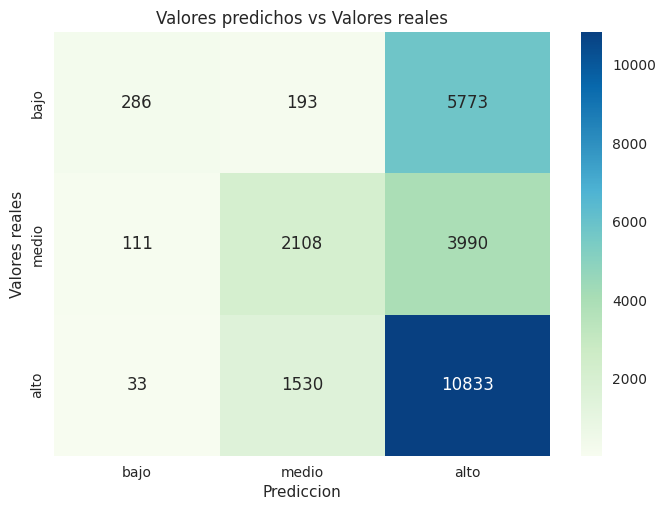

In [52]:
#Creo la matriz de confusión
tabla=confusion_matrix(y_test, y_pred)

#Grafico la matriz de confusión
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g', xticklabels=categories, yticklabels=categories)
plt.title('Valores predichos vs Valores reales')
plt.xlabel('Prediccion')
plt.ylabel('Valores reales')
plt.show()

### Análisis de las métricas obtenidas

In [53]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        alto       0.67      0.05      0.09      6252
        bajo       0.55      0.34      0.42      6209
       medio       0.53      0.87      0.66     12396

    accuracy                           0.53     24857
   macro avg       0.58      0.42      0.39     24857
weighted avg       0.57      0.53      0.45     24857



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7da1cea6-caf2-4c30-b019-068f1fb82c77' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>